In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import seaborn as sns
import corner as corner

In [2]:
%matplotlib notebook
Colour = plt.style.use('tableau-colorblind10')

In [3]:
def Ensure_all(All_variables):
    no_nan_tables = [table.dropna() for table in All_variables]
    
    num_variables = len(no_nan_tables)
    previous_merge = no_nan_tables[0]
    for index in range(1, num_variables):
        current_table = no_nan_tables[index]
        previous_merge = pd.merge(previous_merge, current_table, left_index=True, right_index=True, how='inner')
    return previous_merge

def PlanetRadiusErrors(Ratio, Radius, RatioError, RadiusError):
    Error = np.sqrt((Ratio*RadiusError)**2 + (Radius*RatioError)**2)*const.R_sun/const.R_earth
    return Error

<IPython.core.display.Javascript object>


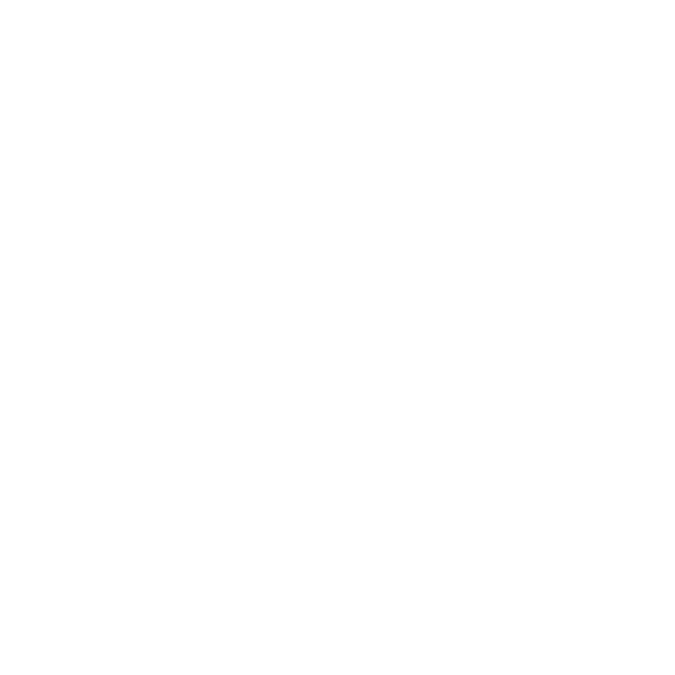

In [4]:
Main_directory = 'C:/Users/Iwan/Documents/GitHub/Iwan-and-George-Year-4-Project'
BASTA_stars = pd.read_csv(f'{Main_directory}/BASTA/Output/GaiaResultsFinal.ascii', index_col='starid' ,sep='\t').dropna()
Planet_data = pd.read_csv(f'{Main_directory}/Samples/Sorted Data/Planets/Final Planets.csv'
                          , index_col='KOI').dropna()

Planet_calc = Planet_data.set_index('Host Gaia DR3 ID')
Valley_data = Ensure_all([BASTA_stars[['radPhot', 'radPhot_errp', 'radPhot_errm']], Planet_calc])

Valley_data['Planet Radii'] = Valley_data['radPhot']*Valley_data['PSR']*const.R_sun/const.R_earth
Valley_data['Planet Rad pe'] = PlanetRadiusErrors(Valley_data['PSR'], Valley_data['radPhot']
                                                  , Valley_data['PSR pme'], Valley_data['radPhot_errp'])
Valley_data['Planet Rad me'] = PlanetRadiusErrors(Valley_data['PSR'], Valley_data['radPhot']
                                                  , Valley_data['PSR pme'], Valley_data['radPhot_errm'])

Valley_data.reset_index(inplace=True)
Valley_data = Valley_data.drop(Valley_data[Valley_data['Planet Radii'] > 4].index)

LogP = np.log10(Valley_data['P'])
Planet_radii = Valley_data['Planet Radii']
Noise = np.array((Valley_data['Planet Rad pe'] + Valley_data['Planet Rad me'])/2)

ax = sns.jointplot(x=LogP, y=Planet_radii
                   , joint_kws={'s':10}, marginal_kws=dict(bins=26, fill=True))
plt.show()

In [5]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import jax
import jax.numpy as jnp

In [6]:
def numpyro_model(D, D_sigma):
    mu0 = numpyro.sample('mu0', dist.Normal(jnp.stack([0.6, 1.5]), jnp.stack([0.2, 0.25])))
    mu1_diff = numpyro.sample('mu1_diff', dist.Normal(jnp.stack([0.65, 1]), jnp.stack([0.2, 0.25])))
    sigma0 = numpyro.sample('sigma0', dist.HalfNormal(2).expand([2]))
    sigma1 = numpyro.sample('sigma1', dist.HalfNormal(2).expand([2]))
    
    Rho0 = numpyro.sample("Rho0", dist.LKJ(2, 2))
    cov0 = jnp.outer(sigma0, sigma0) * Rho0
    
    Rho1 = numpyro.sample("Rho1", dist.LKJ(2, 2))
    cov1 = jnp.outer(sigma1, sigma1) * Rho1
    
    dists = dist.MultivariateNormal(jnp.stack([mu0, mu0 + mu1_diff]), jnp.stack([cov0, cov1]))
    
    mixture = numpyro.sample('mixture', dist.Beta(3.5, 5))
    mix = dist.Categorical(probs=jnp.array([mixture, 1.0 - mixture]))
    
    
    y = numpyro.sample('y', dist.Normal(D[:, 1], D_sigma))
    numpyro.sample('obs', dist.MixtureSameFamily(mix, dists), obs=jnp.stack([D[:, 0], y], axis=-1))

In [7]:
D = np.flipud(np.rot90([LogP, Planet_radii]))

nuts_kernel = NUTS(numpyro_model)
Nsamples = 20000
burnin = Nsamples/5

mcmc = MCMC(nuts_kernel, num_samples=Nsamples, num_warmup=burnin, num_chains=4)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, D, Noise)

posterior_samples = mcmc.get_samples()

C:\Users\Iwan\AppData\Local\Temp\ipykernel_17268\852527631.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_samples=20000, num_warmup=4000, num_chains=4)
sample: 100%|█████████████████████████| 24000/24000 [11:36<00:00, 34.46it/s, 31 steps of size 1.91e-01. acc. prob=0.88]


In [8]:
import arviz as az
az_data = az.from_numpyro(mcmc)
az.summary(az_data)

C:\Users\Iwan\anaconda3\Lib\site-packages\arviz\utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
C:\Users\Iwan\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
C:\Users\Iwan\anaconda3\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Rho0[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,80000.0,80000.0,NaN
"Rho0[0, 1]",-0.172,0.202,-0.593,0.134,0.003,0.002,6597.0,22882.0,1.0
"Rho0[1, 0]",-0.172,0.202,-0.593,0.134,0.003,0.002,6597.0,22882.0,1.0
"Rho0[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,78063.0,75006.0,1.0
"Rho1[0, 0]",1.000,0.000,1.000,1.000,0.000,0.000,80000.0,80000.0,NaN
...,...,...,...,...,...,...,...,...,...
y[519],1.246,0.098,1.067,1.433,0.000,0.000,128002.0,56153.0,1.0
y[520],2.343,0.252,1.870,2.819,0.001,0.000,173091.0,53840.0,1.0
y[521],1.991,0.133,1.741,2.242,0.000,0.000,184919.0,55344.0,1.0
y[522],2.633,0.163,2.329,2.944,0.000,0.000,197498.0,55579.0,1.0


In [9]:
numpyro_samples0 = np.vstack([posterior_samples['mu0'][:, 0], posterior_samples['sigma0'][:, 0], 
                             posterior_samples['mu0'][:, 1], posterior_samples['sigma0'][:, 1], 
                             posterior_samples['Rho0'][:, 0, 1], posterior_samples['mixture']]).T
numpyro_samples1 = np.vstack([posterior_samples['mu0'][:, 0] + posterior_samples['mu1_diff'][:, 0], posterior_samples['sigma1'][:, 0], 
                             posterior_samples['mu0'][:, 1] + posterior_samples['mu1_diff'][:, 1], posterior_samples['sigma1'][:, 1], 
                             posterior_samples['Rho1'][:, 0, 1], posterior_samples['mixture']]).T

In [21]:
np.savetxt('Numpyro Samples 0.txt', numpyro_samples0)
np.savetxt('Numpyro Samples 1.txt', numpyro_samples1)

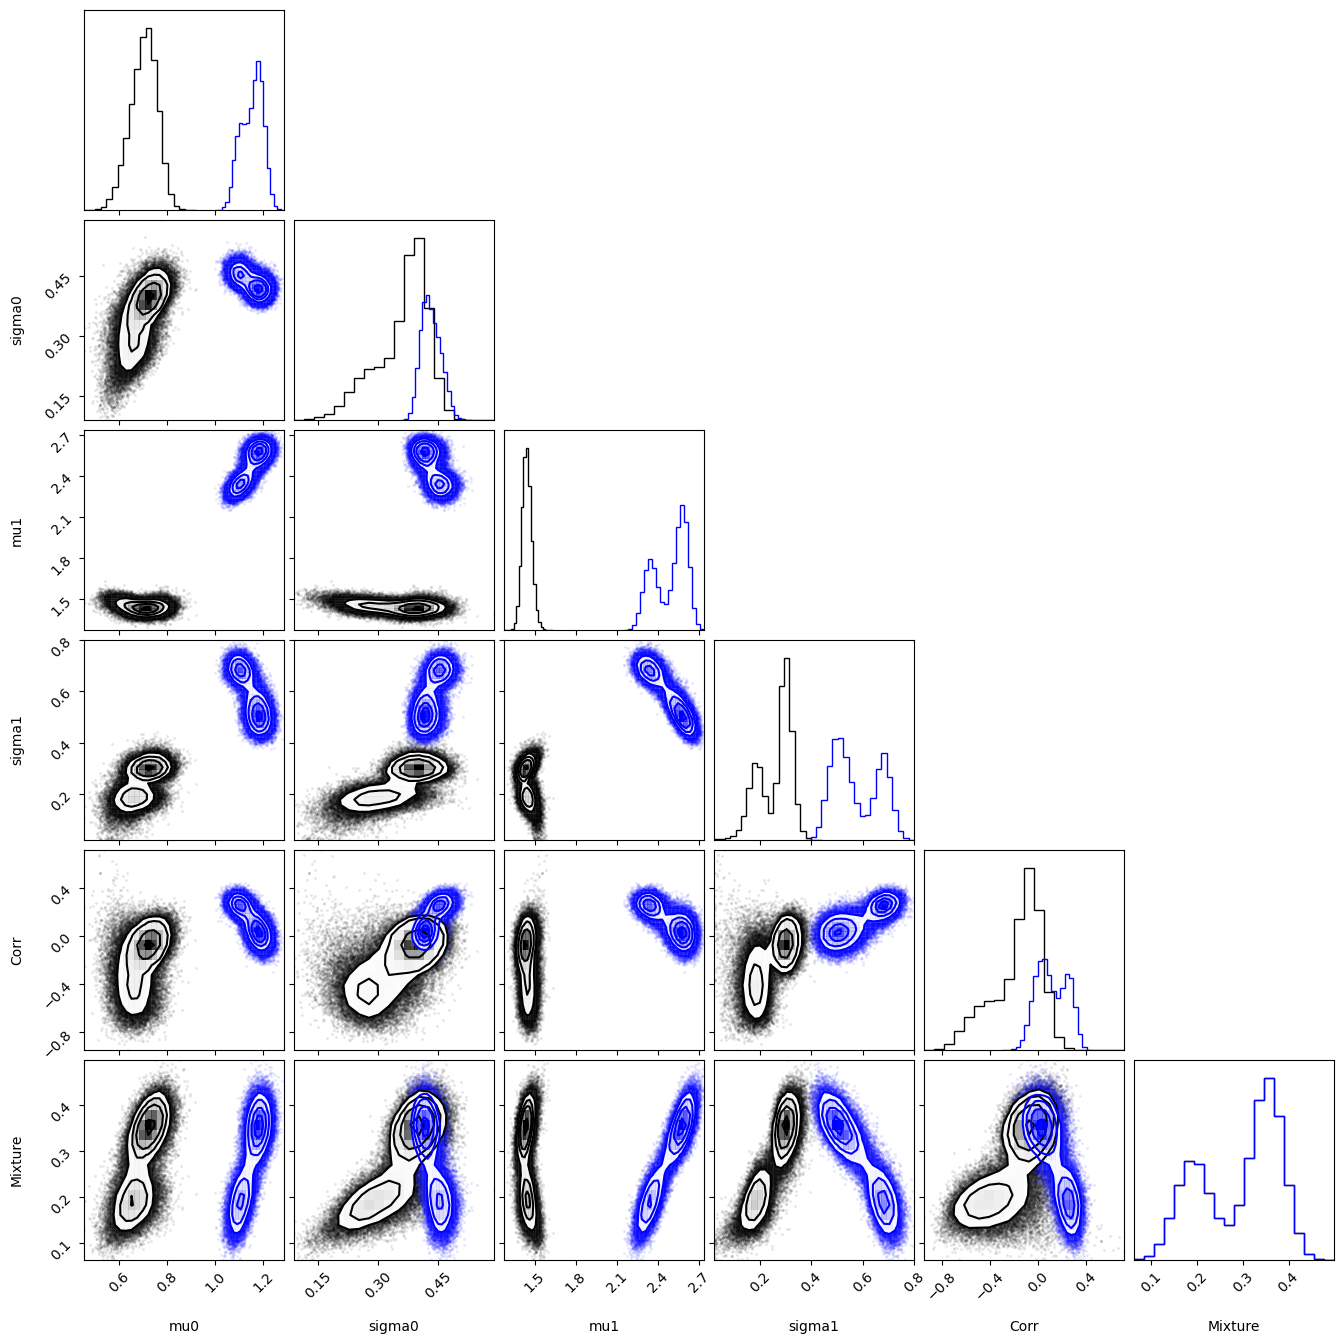

In [15]:
fig = corner.corner(numpyro_samples0, 
              labels=['mu0', 'sigma0', 'mu1', 'sigma1', 'Corr', 'Mixture']);

corner.corner(numpyro_samples1, fig=fig, color='b');
#plt.savefig('HBM Corner')

In [11]:
np.mean(posterior_samples['mixture'])

Array(0.29225263, dtype=float32)

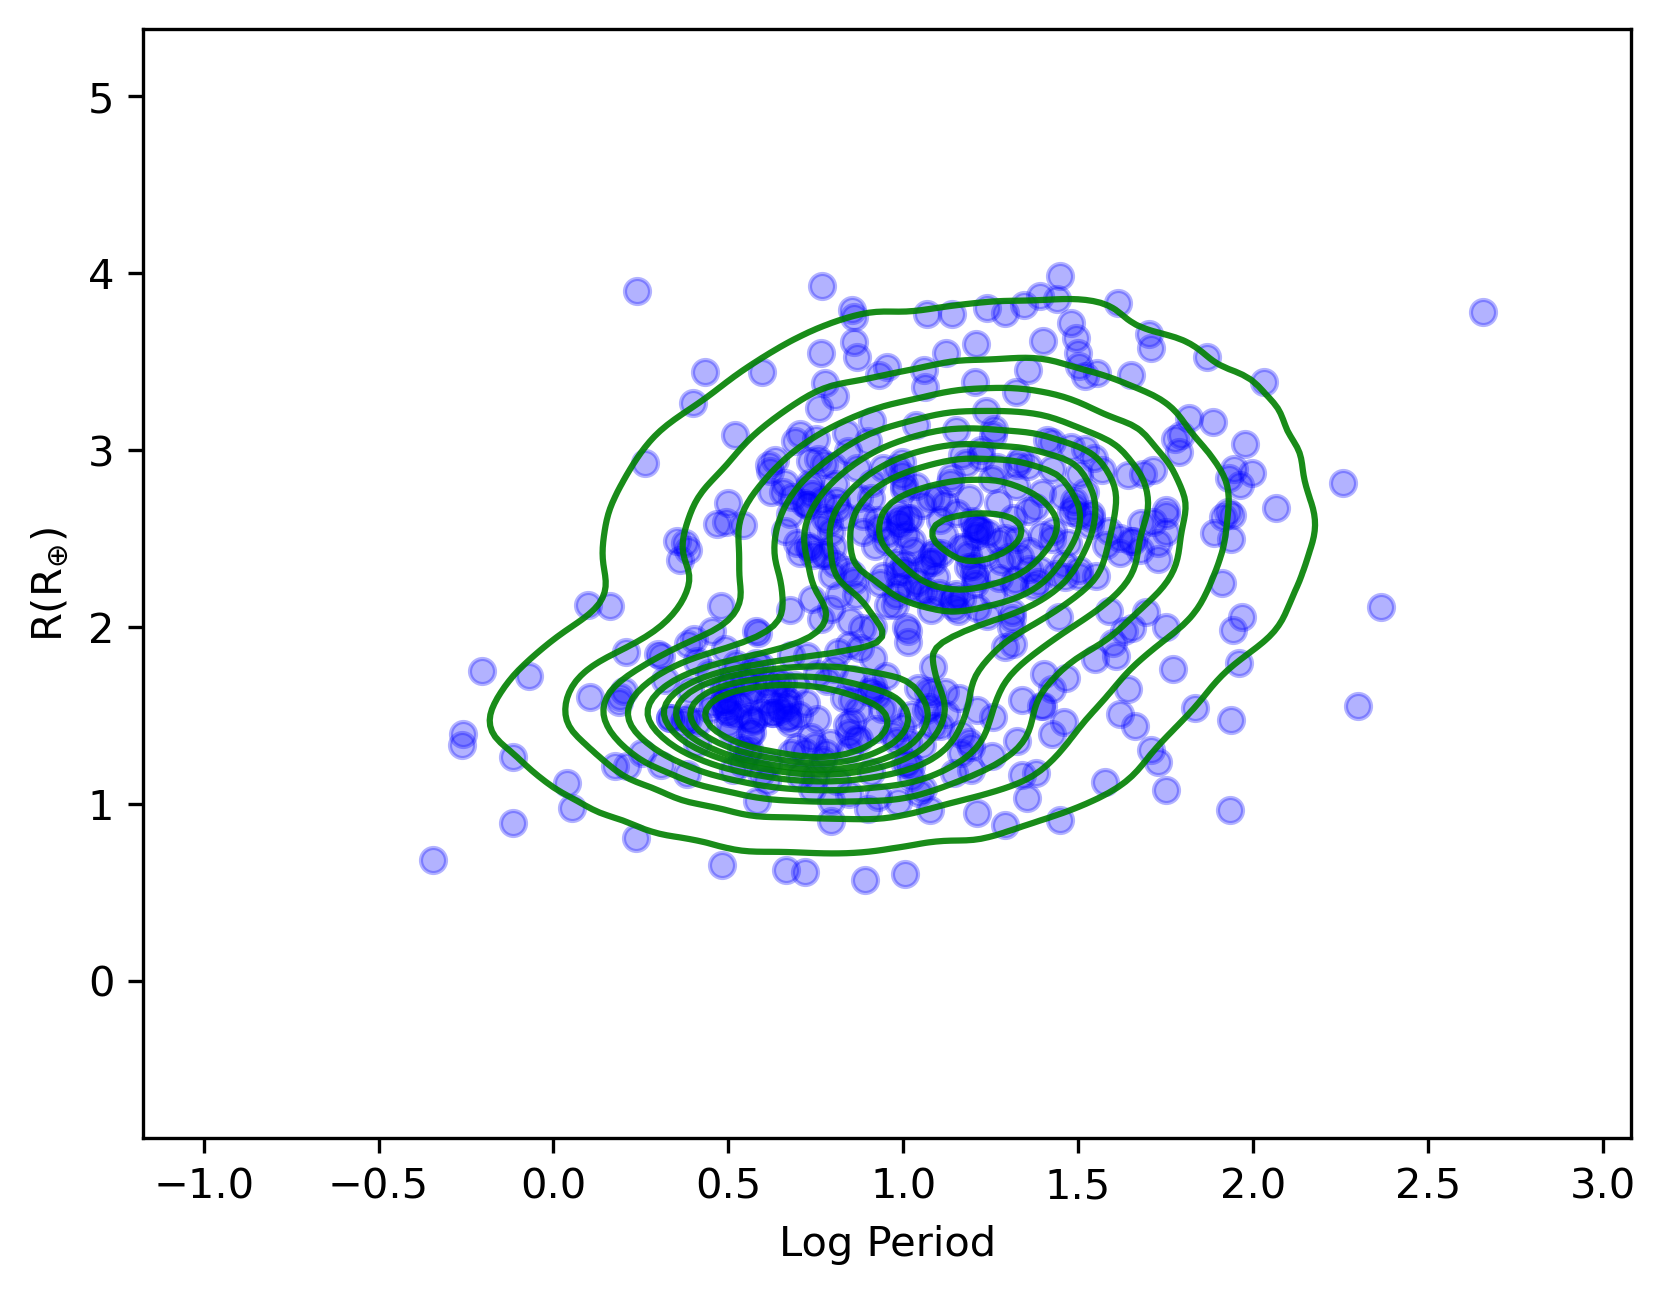

In [24]:
%matplotlib inline

fig,ax = plt.subplots(dpi=300)

new0 = np.array([np.random.multivariate_normal(size=1, mean=[c[0],c[2]], 
                                              cov=[[c[1]**2, c[1]*c[3]*c[4]],[c[1]*c[3]*c[4], c[3]**2]])[0] for c in numpyro_samples0])

new1 = np.array([np.random.multivariate_normal(size=1, mean=[c[0],c[2]], 
                                              cov=[[c[1]**2, c[1]*c[3]*c[4]],[c[1]*c[3]*c[4], c[3]**2]])[0] for c in numpyro_samples1])

post = new0
sel = np.where(np.random.rand(Nsamples) < 1-np.mean(posterior_samples['mixture']))
post[sel] = new1[sel]

sns.kdeplot(x=post[:, 0], y=post[:, 1], alpha=0.9, color='g')

ax.scatter(LogP, Planet_radii, c='b', alpha=0.3)

ax.set_xlabel('Log Period')
ax.set_ylabel('R(R$_{\oplus})$')

plt.savefig('HBM GMM Contour')

[[-0.5  -0.5  -0.5  ... -0.5  -0.5  -0.5 ]
 [-0.49 -0.49 -0.49 ... -0.49 -0.49 -0.49]
 [-0.48 -0.48 -0.48 ... -0.48 -0.48 -0.48]
 ...
 [ 2.47  2.47  2.47 ...  2.47  2.47  2.47]
 [ 2.48  2.48  2.48 ...  2.48  2.48  2.48]
 [ 2.49  2.49  2.49 ...  2.49  2.49  2.49]]
[[0.5  0.51 0.52 ... 3.97 3.98 3.99]
 [0.5  0.51 0.52 ... 3.97 3.98 3.99]
 [0.5  0.51 0.52 ... 3.97 3.98 3.99]
 ...
 [0.5  0.51 0.52 ... 3.97 3.98 3.99]
 [0.5  0.51 0.52 ... 3.97 3.98 3.99]
 [0.5  0.51 0.52 ... 3.97 3.98 3.99]]


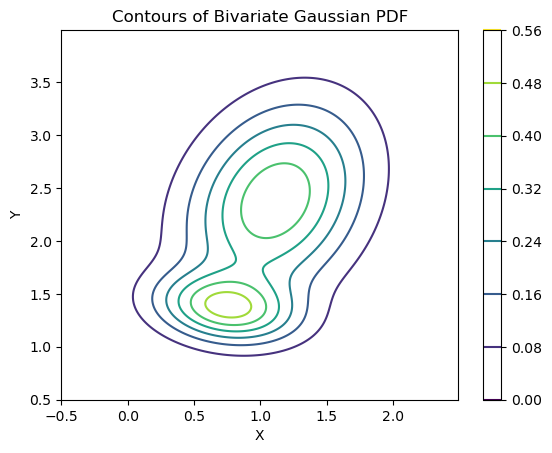

In [13]:
from scipy.stats import multivariate_normal

n = 3

p0 = numpyro_samples0[n]
p1 = numpyro_samples1[n]

Npoints = 1000

μ0 = [p0[0],p0[2]]
Σ0 = [[p0[1]**2, p0[1]*p0[3]*p0[4]],[p0[1]*p0[3]*p0[4], p0[3]**2]]
μ1 = [p1[0],p1[2]]
Σ1 = [[p1[1]**2, p1[1]*p1[3]*p1[4]],[p1[1]*p1[3]*p1[4], p1[3]**2]]
w = posterior_samples['mixture'][n]

'''
new0 = np.random.multivariate_normal(size=Npoints, mean=[p0[0],p0[2]], 
                                              cov=[[p0[1]**2, p0[1]*p0[3]*p0[4]],[p0[1]*p0[3]*p0[4], p0[3]**2]])

new1 =  np.random.multivariate_normal(size=Npoints, mean=[p1[0],p1[2]], 
                                              cov=[[p1[1]**2, p1[1]*p1[3]*p1[4]],[p1[1]*p1[3]*p1[4], p1[3]**2]])

post = new0
sel = np.where(np.random.rand(Npoints) < 1-posterior_samples['mixture'][0])
post[sel] = new1[sel]

fig,ax = plt.subplots(dpi=300)

sns.kdeplot(x=new0[:, 0], y=new0[:, 1], alpha=0.9, color='g')
sns.kdeplot(x=new1[:, 0], y=new1[:, 1], alpha=0.9, color='r')

ax.scatter(new0[:,0], new0[:,1], c='b', alpha=0.3)
ax.scatter(new1[:,0], new1[:,1], c='y', alpha=0.3)
'''
# Create a grid of points
x, y = np.mgrid[-0.5:2.5:.01, 0.5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

# Create the bivariate Gaussian distribution
rv0 = multivariate_normal(μ0, Σ0)
rv1 = multivariate_normal(μ1, Σ1)

# Evaluate the PDF values at each point in the grid
z = w*rv0.pdf(pos) + (1-w)*rv1.pdf(pos)

# Plot the contours
plt.contour(x, y, z)
print(x)
print(y)

# Add a color bar which maps values to colors
plt.colorbar()

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contours of Bivariate Gaussian PDF')

# Show the plot
plt.show()


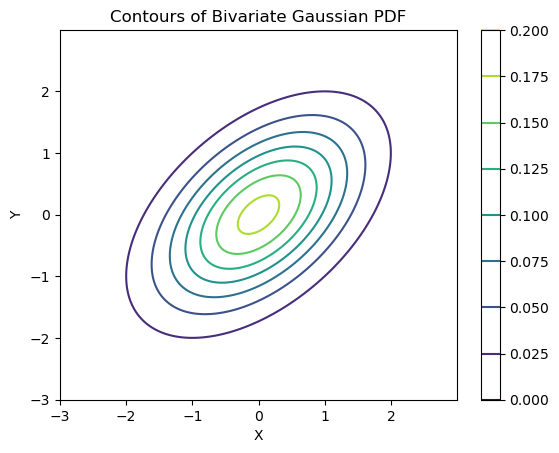

In [14]:
from scipy.stats import multivariate_normal

# Define the parameters for the Gaussian distribution
mu = np.array([0, 0])        # Mean
covariance = np.array([[1, 0.5], [0.5, 1]])  # Covariance matrix

# Create a grid of points
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

# Create the bivariate Gaussian distribution
rv = multivariate_normal(mu, covariance)

# Evaluate the PDF values at each point in the grid
z = rv.pdf(pos)

# Plot the contours
plt.contour(x, y, z)

# Add a color bar which maps values to colors
plt.colorbar()

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contours of Bivariate Gaussian PDF')

# Show the plot
plt.show()